<img src="Data/bottleneck_logo.svg" />

Importation des librairies utilisées dans ce notebook :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Importation des trois fichiers au format excel :

In [2]:
erp = pd.read_excel("Data/erp.xlsx")
liaison = pd.read_excel("Data/liaison.xlsx")
web = pd.read_excel("Data/web.xlsx")

# Analyse du fichier erp (enterprise resource planning)

In [3]:
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


Le fichier ERP est composé de 5 colonnes dont seule la première semble être une bonne candidate pour servir de clé primaire.

Vérifions l'unicité de notre clé primaire en choisissant comme index la colonne "product_id":

In [4]:
# unicité de la PK, l'exécution de cette ligne renvoie une erreur quand la clé n'est pas unique
erp.set_index("product_id", verify_integrity=True)

,onsale_web,price,stock_quantity,stock_status
product_id,,,,
3847,1,24.2,0,outofstock
3849,1,34.3,0,outofstock
3850,1,20.8,0,outofstock
4032,1,14.1,0,outofstock
4039,1,46.0,0,outofstock
...,...,...,...,...
7203,0,45.0,30,instock
7204,0,45.0,9,instock
7247,1,54.8,23,instock


"product_id" est bien une clé primaire de notre fichier erp.

Nous notons cependant un problème de redondance possible entre les colonnes "stock_quantity et "stock_status", des erreurs peuvent apparaître comme à la ligne 443 :

In [5]:
# recherche de produit en stock avec une quantité nulle
erp[(erp["stock_status"] == "instock") & (erp["stock_quantity"] == 0)]

,product_id,onsale_web,price,stock_quantity,stock_status
443,4954,1,25.0,0,instock


Il s'agit de la ligne correspondant aux bons-cadeaux mais des erreurs de saisie pourraient apparaître sur les autres produits.

In [6]:
# recherche de valeurs NaN
erp.isna().mean()

product_id        0.0
onsale_web        0.0
price             0.0
stock_quantity    0.0
stock_status      0.0
dtype: float64

Ce fichier ne contient pas de valeurs manquantes

Utilisons la méthode describe() sur les colonnes prix et quantité en stock

In [7]:
erp[["price", "stock_quantity"]].describe()

,price,stock_quantity
count,825.000000,825.000000
mean,32.415636,26.496970
std,26.795849,45.892422
min,5.200000,0.000000
25%,14.600000,1.000000
50%,24.400000,11.000000
75%,42.000000,34.000000
max,225.000000,578.000000


Les 2 colonnes semblent contenir des valeurs abberantes ou atypiques, les valeurs maximales sont très éloignés de la moyenne.

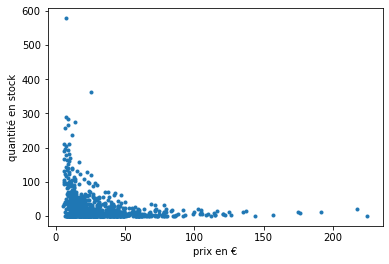

In [8]:
# visualisation des variables prix et quantité en stock
plt.scatter(erp.price, erp.stock_quantity,marker='.')
plt.xlabel("prix en €")
plt.ylabel("quantité en stock")
plt.show()

La visualisation des 2 variables dans un nuage de points nous montre que les produits avec un prix élevé sont en petite quantité. D'autre part nous relevons un produit présent en grande quantité et à un prix proche de notre moyenne.

In [9]:
erp.loc[erp["stock_quantity"]>300]

,product_id,onsale_web,price,stock_quantity,stock_status
130,4208,1,7.6,578,instock
707,6207,1,25.2,363,instock


L'analyse du fichier erp met en lumière la présence d'outliers dans les prix des produits et dans les stocks enregistrés. Une vérification des prix des produits ainsi qu'un inventaire des stocks sont donc à envisager. Nous étudierons plus loin ces 2 variables.

La colonne onsale_web nous indique la présence ou l'absence des produits en ligne :

In [10]:
# recherche de produits en stock absents en ligne
erp_off = erp[(erp["onsale_web"] == 0) & (erp.stock_quantity != 0)]
print (len(erp_off), "produits ne sont pas disponibles en ligne alors qu'ils sont disponibles en stock.")

# recherche de produits ni en stock ni en ligne
erp_off_off = erp[(erp["onsale_web"] == 0) & (erp.stock_quantity == 0)]
print (len(erp_off_off), "produits ne sont plus disponibles ni en ligne ni en stock.")

64 produits ne sont pas disponibles en ligne alors qu'ils sont disponibles en stock.
44 produits ne sont plus disponibles ni en ligne ni en stock.


Ces 44 produits sont des références passées dont une trace reste dans le fichier ERP. Si un réapprovisionnement de ces produits n'est pas possible ou envisageable, ces références peuvent être enlevées du fichier.

# Analyse du fichier liaison

In [11]:
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [12]:
# recherche de valeurs NaN
liaison.isnull().mean()

product_id    0.000000
id_web        0.110303
dtype: float64

Nous remarquons 11% de valeurs manquantes sur la colonne id_web

In [13]:
# comparaison du nombre de valeurs de chaque colonne
# nous enlevons 1 au len(liaison.id_web.unique()) correspondant au premier Nan
print("Nous avons", len(liaison.id_web.unique())-1, "identifiants id_web contre", len(liaison.product_id.unique()), "identifiants produits")

Nous avons 734 identifiants id_web contre 825 identifiants produits


In [14]:
# calcul du nombre de Nan dans la colonne id_web
print(len(liaison[liaison.id_web.isnull()]), "produits n'ont pas de référencement sur le site(qu'ils soient ou non disponibles en stock)")

91 produits n'ont pas de référencement sur le site(qu'ils soient ou non disponibles en stock)


Il est primordial que ce fichier de correspondance ente l'erp et le sku soit complété. L'impact de ces erreurs sera étudié plus loin. Nous allons enlevé les lignes contenant des valeurs manquantes et tester l'unicité des 2 clés primaires "product_id" et "id_web"

In [15]:
# suppression des lignes Nan
liaison = liaison[liaison["id_web"].notna()]

# unicité de la clé "product_id"
liaison.set_index("product_id", verify_integrity=True)

# unicité de la clé "id_web"
liaison.set_index("id_web", verify_integrity=True)

,product_id
id_web,
15298,3847
15296,3849
15300,3850
19814,4032
19815,4039
...,...
15891,7023
15887,7025
13127-1,7247


Pas de message d'erreurs, nos 2 colonnes sont de bonnes candidates en tant que clé primaire.

# Analyse du fichier web

In [16]:
web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0,10,taxable,NaN,1,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0
1,15298,0,0,0,0,6,taxable,NaN,2,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0
2,15296,0,0,0,0,0,taxable,NaN,2,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0
3,15300,0,0,0,0,0,taxable,NaN,2,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0
4,19814,0,0,0,0,3,taxable,NaN,2,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0


Le fichier 'web' est très fourni en informations, beaucoup de colonnes dont certaines ne contiennent pas d'informations pertinentes (pour le moment). La 1e colonne permet d'identifier le produit grâce à son id_web. Le nom de colonne peut être changé pour plus de clarté :

In [17]:
# renommage de la colonne sku
web = web.rename(columns = {'sku':'id_web'})

# suppression des colonnes non essentielles à notre analyse pour nos calculs
web_light = web[["id_web", "total_sales", "tax_status"]]

# recherche de Nan dans la PK
web[web["id_web"].isna()]

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
448,NaN,0,0,0,0,0,taxable,NaN,2,2018-07-31 12:07:23,...,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0
449,NaN,0,0,0,0,0,taxable,NaN,2,2018-08-08 11:23:43,...,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0


Les ligne 448 et 449 n'ont pas d'identifiant web, les produits peuvent être choisis mais les demandes n'aboutiront pas. Nous pourrions garder ces lignes en leur attribuant un id_web provisoire, ces lignes ne seront toutefois pas conservées lors des jointures (pas de correspondance dans le fichier liaison). Le nombre de ventes étant nul, celà n'affectera pas nos calculs.

Notre fichier contient 1430 lignes, beaucoup plus que le nombre de produits listés sur le site. Recherchons la présence de doublons :

In [18]:
web.duplicated(["id_web"])

0       False
1       False
2       False
3       False
4       False
        ...  
1425     True
1426     True
1427     True
1428     True
1429     True
Length: 1430, dtype: bool

La fin de notre dataframe contient des doublons, nous allons les supprimer tout en gardant nos 2 lignes NaN :

In [19]:
# modification du df pour garder les premières occurences et les 2 Nan
web = web[(~web.duplicated(["id_web"])) | (web["id_web"].isna())]
web.shape

(716, 28)

Il sera préférable de diviser le fichier web en plusieurs fichiers plus facilement modifiable qu'un seul fichier de grande taille. Un de ces fichiers pourra par exemple contenir les éléments descriptifs du produit (invariables), un autre, les retours clients...

# Jointure des fichiers

Nous commençons par ajouter la colonne id_web à notre fichier erp : 

In [20]:
erp_liaison = pd.merge(erp, liaison, on="product_id", how="right")
erp_liaison

,product_id,onsale_web,price,stock_quantity,stock_status,id_web
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
...,...,...,...,...,...,...
729,7023,1,27.5,15,instock,15891
730,7025,1,69.0,2,instock,15887
731,7247,1,54.8,23,instock,13127-1
732,7329,0,26.5,14,instock,14680-1


Nous pouvons joindre le df web au df erp_liaison :

In [21]:
web_erp = web.merge(erp_liaison, on="id_web", how="inner")
print("Le dataframe final comporte", web_erp.shape[0], "lignes et", web_erp.shape[1], "colonnes")
web_erp

Le dataframe final comporte 714 lignes et 33 colonnes


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,guid,menu_order,post_type,post_mime_type,comment_count,product_id,onsale_web,price,stock_quantity,stock_status
0,bon-cadeau-25-euros,0,0,0,0,10,taxable,NaN,1,2018-06-01 13:53:46,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,4954,1,25.0,0,instock
1,15298,0,0,0,0,6,taxable,NaN,2,2018-02-08 12:58:52,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,3847,1,24.2,0,outofstock
2,15296,0,0,0,0,0,taxable,NaN,2,2018-02-08 13:49:41,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,3849,1,34.3,0,outofstock
3,15300,0,0,0,0,0,taxable,NaN,2,2018-02-08 14:08:36,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,3850,1,20.8,0,outofstock
4,19814,0,0,0,0,3,taxable,NaN,2,2018-02-09 14:01:05,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,4032,1,14.1,0,outofstock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,16135,0,0,0,0,5,taxable,NaN,2,2020-04-25 13:22:38,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,6930,1,8.4,83,instock
710,15891,0,0,0,0,0,taxable,NaN,2,2020-05-02 14:53:40,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,7023,1,27.5,15,instock
711,15887,0,0,0,0,0,taxable,NaN,2,2020-05-02 15:00:54,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,7025,1,69.0,2,instock
712,13127-1,0,0,0,0,0,taxable,NaN,2,2020-06-09 15:42:04,...,https://www.bottle-neck.fr/?post_type=product&...,0,product,NaN,0,7247,1,54.8,23,instock


Nous pouvons créer le fichier Excel correspondant :

In [22]:
web_erp.to_excel(r'df_bottleneck.xlsx', index=False)

# Résultats

## Chiffre d'affaires par produit

Pour calculer le chiffre d'affaires par produit, nous allons utiliser le dataframe de jointure des 3 fichiers excel et y ajouter une colonne "Chiffre d'affaires":

In [23]:
# ajout d'une colonne ca
web_erp["chiffre d'affaires (en €)"] = (web_erp.price * web_erp.total_sales)
print("Chiffre d'affaires par produit :")

# affichage des 20 meilleures ventes
web_erp = web_erp.sort_values("chiffre d'affaires (en €)", ascending=False)
web_erp.head(20)

Chiffre d'affaires par produit :


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,menu_order,post_type,post_mime_type,comment_count,product_id,onsale_web,price,stock_quantity,stock_status,chiffre d'affaires (en €)
195,7818,0,0,0,0,96,taxable,NaN,2,2018-03-01 14:02:44,...,0,product,NaN,0,4334,1,49.0,0,outofstock,4704.0
72,1662,0,0,0,0,87,taxable,NaN,2,2018-02-13 13:17:25,...,0,product,NaN,0,4144,1,49.0,11,instock,4263.0
219,3510,0,0,0,0,13,taxable,NaN,2,2018-03-22 11:21:05,...,0,product,NaN,0,4402,1,176.0,8,instock,2288.0
71,11641,0,0,0,0,30,taxable,NaN,2,2018-02-13 13:08:44,...,0,product,NaN,0,4142,1,53.0,8,instock,1590.0
70,304,0,0,0,0,40,taxable,NaN,2,2018-02-13 12:57:44,...,0,product,NaN,0,4141,1,39.0,1,instock,1560.0
202,12589,0,0,0,0,11,taxable,NaN,2,2018-03-02 10:46:10,...,0,product,NaN,0,4355,1,126.5,2,instock,1391.5
200,15940,0,0,0,0,5,taxable,NaN,2,2018-03-02 10:30:04,...,0,product,NaN,0,4352,1,225.0,0,outofstock,1125.0
80,16237,0,0,0,0,36,taxable,NaN,2,2018-02-13 14:13:53,...,0,product,NaN,0,4153,1,29.0,0,outofstock,1044.0
651,16580,0,0,0,0,41,taxable,NaN,2,2019-07-24 09:31:48,...,0,product,NaN,0,6206,1,25.2,120,instock,1033.2
31,16416,0,0,0,0,62,taxable,NaN,2,2018-02-12 13:42:28,...,0,product,NaN,0,4068,1,16.6,157,instock,1029.2


## Chiffre d'affaires total

Nous pouvons faire la somme de cette colonne pour connaître le chiffre d'affaires réalisé en ligne :

In [24]:
# calcul du total
ca = web_erp["chiffre d\'affaires (en €)"].sum()
print ("le chiffre d'affaires est de",ca,"€")

le chiffre d'affaires est de 70568.6 €


## CA non réalisé par manque de référencement

Calculons le CA des produits en stock sans identifiant sur le site. Pour celà nous reprenons le dataframe créé lors de l'analyse du fichier liaison :

In [25]:
#calcul du CA
erp_off_ca = (erp_off["price"] * erp_off["stock_quantity"]).sum()
print(len(erp_off), "produits ne sont pas référencés en ligne mais sont en stock, pour un CA potentiel de", erp_off_ca,"€")

64 produits ne sont pas référencés en ligne mais sont en stock, pour un CA potentiel de 41455.5 €


# Etude de la variable Prix

## Visualisation de la variable

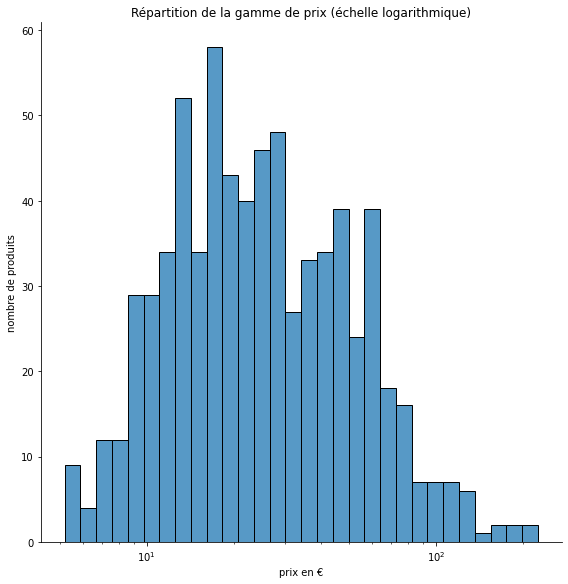

In [26]:
# représentation en histogramme de la variable Prix
sns.displot(web_erp, x="price", log_scale=True, bins=30, height=8)
plt.xlabel("prix en €")
plt.ylabel("nombre de produits")
plt.title("Répartition de la gamme de prix (échelle logarithmique)")
plt.show()

Les prix ne sont pas distribués normalement mais ils semblent suivre une distri log-normale

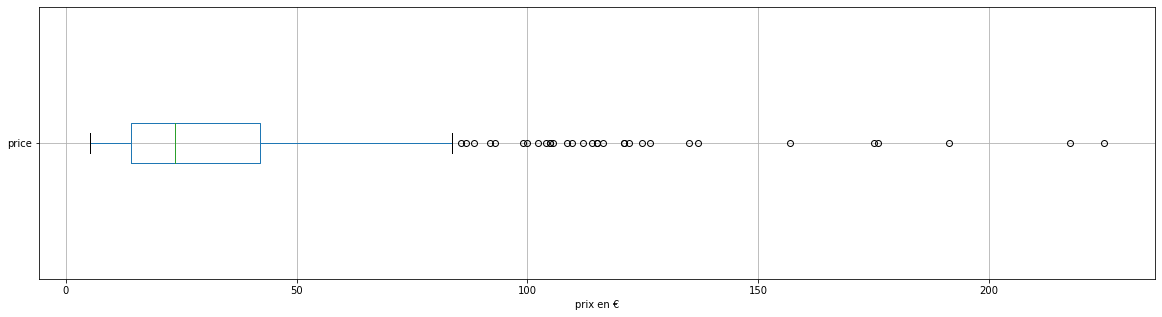

In [27]:
# représentation sous forme de boxplot
plt.figure(figsize=(20,5))
web_erp.boxplot(column="price", vert=False)
plt.xlabel("prix en €")
plt.show()

Nous remarquons la présence d'outliers, nous allons donc les étudier plus en détail.

## Analyse des outliers



In [28]:
#IQR
Q1 = np.quantile(erp["price"], 0.25)
Q3 = np.quantile(erp["price"], 0.75)
IQR = Q3 - Q1
seuil_IQR = Q3 + 1.5 * IQR
nb_outliers = len(erp[erp["price"] > seuil_IQR])

print("Avec la méthode de l'écart interquartile :")
print("     valeur de Q1 :", Q1)
print("     valeur de Q3 :", Q3)
print("     l'IQR de la colonne prix est :", IQR)
print("     Nombre d'outliers :", nb_outliers,)
print("     le seuil des outliers est de", seuil_IQR, "€")
print("")

#z-score
mean = np.mean(erp.price)
std = np.std(erp.price)
seuil = 2
z_score_outlier = [i for i in erp.price if (i-mean)/std > seuil]
seuil_Z = seuil * std + mean

print ("Avec la méthode du z-score :")
print("     Les outliers sont au nombre de", len(z_score_outlier))
print("     Le seuil des  outliers est de",round(seuil_Z,2), "€")
print("")

#moyenne des 2 seuils
seuil_prix = (seuil_IQR + seuil_Z) / 2
print("Nous retiendrons",round(seuil_prix,2), "€ comme valeur seuil pour nos outliers")

Avec la méthode de l'écart interquartile :
     valeur de Q1 : 14.6
     valeur de Q3 : 42.0
     l'IQR de la colonne prix est : 27.4
     Nombre d'outliers : 37
     le seuil des outliers est de 83.1 €

Avec la méthode du z-score :
     Les outliers sont au nombre de 34
     Le seuil des  outliers est de 85.97 €

Nous retiendrons 84.54 € comme valeur seuil pour nos outliers


Les 2 méthodes nous donnent des nombres d'outliers proches (37 et 34) et des valeurs de seuil assez similaires.

Nous pouvons étudier plus spécifiquement ces valeurs pour différencier atypiques et aberrantes:

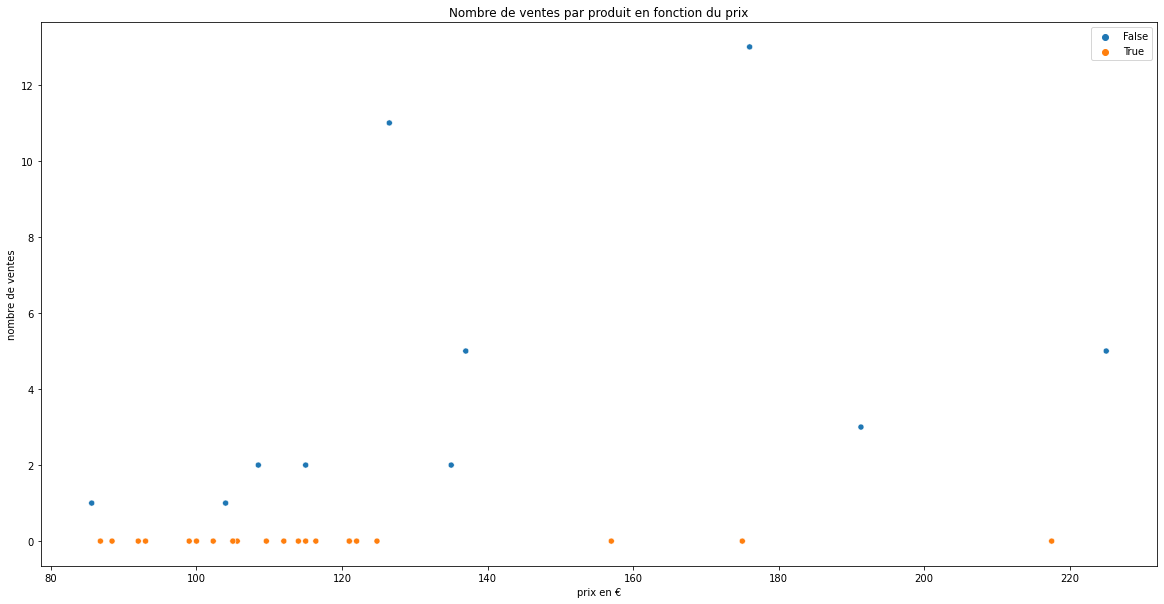

In [29]:
# df composé des outliers
web_erp_outliers = web_erp[web_erp.price > 84.54]

# condition valeurs aberrantes
aber= ((web_erp_outliers["price"] > 84.54) & (web_erp_outliers["total_sales"] == 0))

# nuage de points "nombre de ventes"/"prix"
plt.figure(figsize=(20,10))
sns.scatterplot(data=web_erp_outliers, x='price', y='total_sales', marker='o', hue=aber)
plt.xlabel("prix en €")
plt.ylabel("nombre de ventes")
plt.title("Nombre de ventes par produit en fonction du prix")
plt.show()

Les prix relevés comme outliers ont pour certains un nombre de ventes supérieur à 0, ce sont donc des valeurs atypiques représentées ici par des points bleus : par exemple, le produit 4352 à 225€ a été vendu 5 fois pour un total de 1125€.

Les valeurs représentées par des points orange semblent plutôt indiquées des valeurs aberrantes. Toutefois la distinction en valeurs atypiques ne peut se faire que si des ventes sont réalisées.

## Valeurs atypiques

In [30]:
# liste des valeurs atypiques
web_erp_atypiques = web_erp_outliers[web_erp_outliers.total_sales > 0]
print("liste des", len(web_erp_atypiques), "valeurs atypiques")
web_erp_atypiques

liste des 10 valeurs atypiques


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,menu_order,post_type,post_mime_type,comment_count,product_id,onsale_web,price,stock_quantity,stock_status,chiffre d'affaires (en €)
219,3510,0,0,0,0,13,taxable,NaN,2,2018-03-22 11:21:05,...,0,product,NaN,0,4402,1,176.0,8,instock,2288.0
202,12589,0,0,0,0,11,taxable,NaN,2,2018-03-02 10:46:10,...,0,product,NaN,0,4355,1,126.5,2,instock,1391.5
200,15940,0,0,0,0,5,taxable,NaN,2,2018-03-02 10:30:04,...,0,product,NaN,0,4352,1,225.0,0,outofstock,1125.0
382,14220,0,0,0,0,5,taxable,NaN,2,2018-05-15 10:23:41,...,0,product,NaN,0,4904,1,137.0,13,instock,685.0
587,14983,0,0,0,0,3,taxable,NaN,2,2019-03-28 10:21:36,...,0,product,NaN,0,5892,1,191.3,10,instock,573.9
642,14923,0,0,0,0,2,taxable,NaN,2,2019-06-28 17:22:27,...,0,product,NaN,0,6126,1,135.0,10,instock,270.0
653,13996,0,0,0,0,2,taxable,NaN,2,2019-07-25 09:09:17,...,0,product,NaN,0,6212,1,115.0,2,instock,230.0
220,3507,0,0,0,0,2,taxable,NaN,2,2018-03-22 11:32:55,...,0,product,NaN,0,4404,1,108.5,2,instock,217.0
223,3509,0,0,0,0,1,taxable,NaN,2,2018-03-22 11:49:53,...,0,product,NaN,0,4407,1,104.0,6,instock,104.0
206,13853,0,0,0,0,1,taxable,NaN,2,2018-03-02 11:11:48,...,0,product,NaN,0,4359,1,85.6,0,outofstock,85.6


In [31]:
# CA
ca_atyp = web_erp_atypiques["chiffre d\'affaires (en €)"].sum()
prop = ca_atyp * 100 / ca
print ("le chiffre d'affaires des produits dont le prix est atypique est de",ca_atyp,"€")
print ("cela représente", round(prop,2), "% du CA total")

le chiffre d'affaires des produits dont le prix est atypique est de 6970.0 €
cela représente 9.88 % du CA total


## Valeurs aberrantes

In [32]:
# liste des valeurs aberrantes
web_erp_aberrantes = web_erp_outliers[web_erp_outliers.total_sales == 0]
print("liste des", len(web_erp_aberrantes), "valeurs aberrantes")
web_erp_aberrantes

liste des 22 valeurs aberrantes


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,menu_order,post_type,post_mime_type,comment_count,product_id,onsale_web,price,stock_quantity,stock_status,chiffre d'affaires (en €)
553,15185,0,0,0,0,0,taxable,NaN,2,2019-03-13 14:43:22,...,0,product,NaN,0,5767,1,175.0,12,instock,0.0
602,14774,0,0,0,0,0,taxable,NaN,2,2019-04-04 16:39:24,...,0,product,NaN,0,5916,1,93.0,3,instock,0.0
604,14773,0,0,0,0,0,taxable,NaN,2,2019-04-04 17:01:54,...,0,product,NaN,0,5918,1,114.0,8,instock,0.0
603,14775,0,0,0,0,0,taxable,NaN,2,2019-04-04 16:49:37,...,0,product,NaN,0,5917,1,122.0,4,instock,0.0
647,14596,0,0,0,0,0,taxable,NaN,2,2019-07-23 10:37:14,...,0,product,NaN,0,6201,1,105.6,7,instock,0.0
648,15126,0,0,0,0,0,taxable,NaN,2,2019-07-23 10:50:24,...,0,product,NaN,0,6202,1,116.4,14,instock,0.0
657,15070,0,0,0,0,0,taxable,NaN,2,2019-07-25 09:31:09,...,0,product,NaN,0,6216,1,121.0,6,instock,0.0
654,15072,0,0,0,0,0,taxable,NaN,2,2019-07-25 09:10:32,...,0,product,NaN,0,6213,1,121.0,7,instock,0.0
655,11601,0,0,0,0,0,taxable,NaN,2,2019-07-25 09:15:41,...,0,product,NaN,0,6214,1,99.0,7,instock,0.0
656,12790,0,0,0,0,0,taxable,NaN,2,2019-07-25 09:30:16,...,0,product,NaN,0,6215,1,115.0,4,instock,0.0


Les produits ci-dessus sont classés dans la catégorie "valeurs aberrantes", aucune vente n'ayant été faite (pour ceux ayant un stock positif). Il peut y avoir quelques valeurs atypiques mais il n'est pas possible de les distinguer avec les données que nous avons.

# Etude de la variable Quantité en stock

Une approche similaire peut être menée avec les quantités en stock :

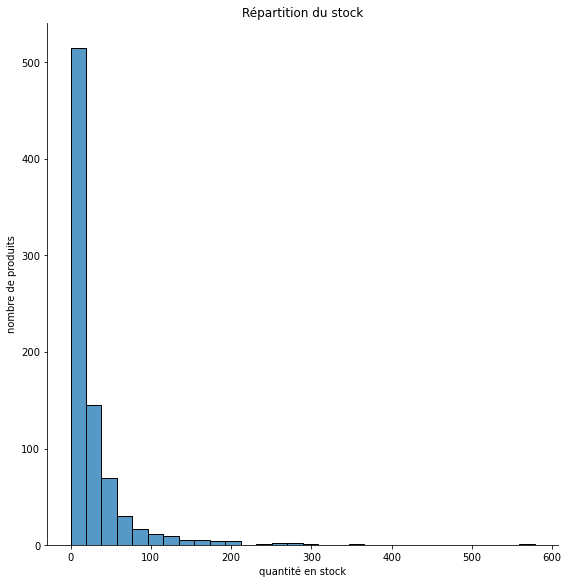

In [33]:
# représentation en histogramme de la variable Quantité en stock
sns.displot(erp, x="stock_quantity", bins=30, height=8)
plt.xlabel("quantité en stock")
plt.ylabel("nombre de produits")
plt.title("Répartition du stock")
plt.show()

Nous voyons sur cet histogramme que 2 produits ont une quantité en stock supérieure à 300, ce qui semble hautement improbable

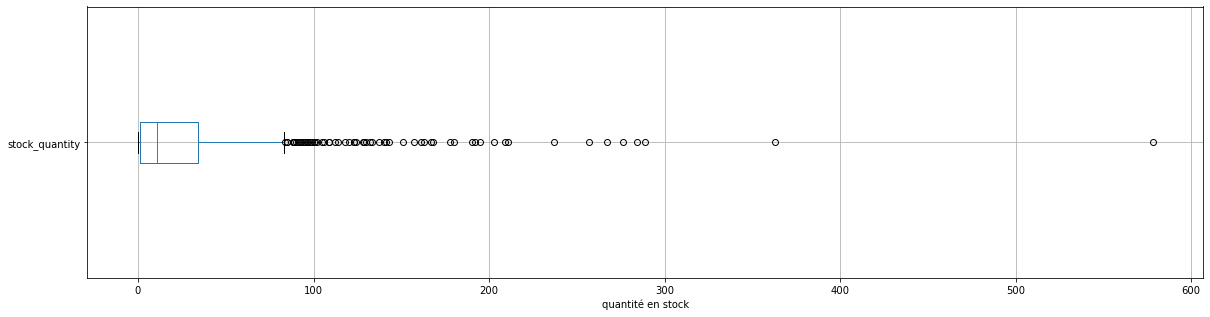

In [34]:
# représentation sous forme de boxplot
plt.figure(figsize=(20,5))
erp.boxplot(column="stock_quantity", vert=False)
plt.xlabel("quantité en stock")
plt.show()

In [35]:
# méthode IQR
Q3 = np.quantile(erp["stock_quantity"], 0.75)
Q1 = np.quantile(erp["stock_quantity"], 0.25)
IQR = Q3 - Q1
seuil_sup = Q3 + 1.5 * IQR
nb_outliers = len(erp[erp["stock_quantity"] > seuil_sup])

print("l'écart interquartile de la colonne quantité en stock est:", IQR)
print("le seuil des outliers est", seuil_sup)
print("il y a", nb_outliers,"outliers dans la colonne quantité en stock")

# méthode Z-score
mean = np.mean(erp["stock_quantity"])
std = np.std(erp["stock_quantity"])
seuil = 2
z_score_outlier = [i for i in erp["stock_quantity"] if (i-mean)/std > seuil]
seuil_outlier = seuil * std + mean

print("Avec la méthode du z-score:")
print("      les outliers sont au nombre de", len(z_score_outlier))
print("      Valeur au delà de laquelle on considère être en présence d'un outlier:",round(seuil_outlier,2))

l'écart interquartile de la colonne quantité en stock est: 33.0
le seuil des outliers est 83.5
il y a 63 outliers dans la colonne quantité en stock
Avec la méthode du z-score:
      les outliers sont au nombre de 35
      Valeur au delà de laquelle on considère être en présence d'un outlier: 118.23


Un inventaire des stocks semble approprié pour une meilleure gestion. Nous n'avons pas d'autres données (e.g. stock initial) pour étudier ces valeurs.

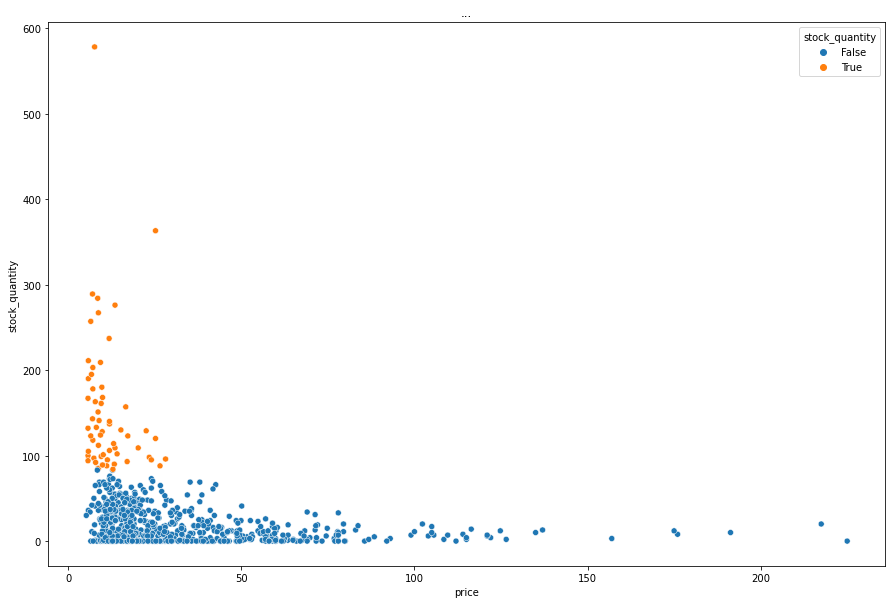

In [36]:
# condition outlier
outlier2 = (web_erp["stock_quantity"] > 83)

# nuage de points 
plt.figure(figsize=(15,10))
sns.scatterplot(data=web_erp, y='stock_quantity', x='price', marker='o', hue=outlier2)
#plt.xlabel("quantité en stock")
#plt.ylabel("nombre de ventes")
plt.title("...")
plt.show()